# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [2]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

In [3]:

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2023-03-21 22:38:11--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.121.120
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.121.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip.1’

dogImages.zip.1      13%[=>                  ] 144.99M  35.9MB/s    eta 28s    ^C
Archive:  dogImages.zip
replace dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [4]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import os
import logging

import sagemaker
import boto3
from torchvision import datasets, models, transforms
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

/opt/conda/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.


The dataset contains 6680 train images, 835 validation images and 837 test images of dogs of 133 breeds. 
Median number of images of each class in training set is 19. Maximum number is 38, minimum - 8

In [5]:
FOLDERS = ['train', 'valid', 'test']

In [6]:
data_transforms = {
    x: transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
    ]) 
    for x in FOLDERS
}

In [7]:
data_dir = 'dogImages'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]
                                         )
                  for x in FOLDERS}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True)
               for x in FOLDERS}
class_names = image_datasets['train'].classes
NUM_CLASSES = len(class_names)
print("number of classes:{}".format(NUM_CLASSES))

inputs, classes = next(iter(dataloaders['train']))


number of classes:133
[2023-03-21 22:39:12.273 pytorch-1-10-cpu-py38-ml-t3-medium-9c8fa3a7688fa232cbbe37185a11:27 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


/opt/conda/lib/python3.8/site-packages/smdebug-1.0.13b20220304-py3.8.egg/smdebug/profiler/system_metrics_reader.py:63: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/opt/conda/lib/python3.8/site-packages/smdebug-1.0.13b20220304-py3.8.egg/smdebug/profiler/system_metrics_reader.py:63: SyntaxWarning: "is not" with a literal. Did you mean "!="?


[2023-03-21 22:39:12.761 pytorch-1-10-cpu-py38-ml-t3-medium-9c8fa3a7688fa232cbbe37185a11:27 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


AttributeError: 'BarContainer' object has no attribute 'show'

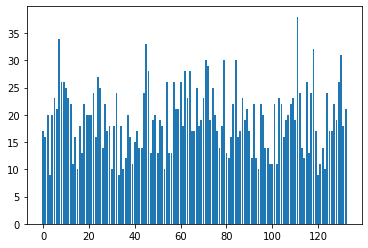

In [8]:
train_values = [len(image_datasets['train'].classes[i]) 
          for i in range(NUM_CLASSES)]

fig = plt.bar(range(NUM_CLASSES), train_values)
fig.show()

In [ ]:
print(np.median(train_values), np.max(train_values), np.min(train_values))

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated



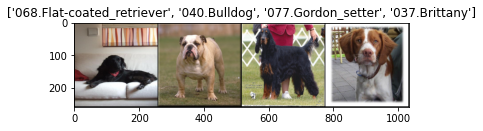

In [10]:
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [11]:
# #TODO: Fetch and upload the data to AWS S3
# sagemaker_session = sagemaker.Session()
# bucket = sagemaker_session.default_bucket()
# prefix = "sagemaker/DogBreedClassification"
# s3_dataset_path = sagemaker_session.upload_data(path="dogImages", bucket=bucket, key_prefix=prefix)
# print("input spec (in this case, just an S3 path): {}".format(s3_dataset_path))

In [12]:
s3_dataset_path = 's3://sagemaker-us-east-1-222248610835/sagemaker/DogBreedClassification/'

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [13]:
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

In [14]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.01),
    "batch-size": CategoricalParameter([16, 32, 64, 128, 256]),
    "momentum": ContinuousParameter(0.0, 0.99),
}

In [15]:
objective_metric_name = "validation:accuracy"
objective_type = "Maximize"
metric_definitions = [{"Name": "validation:accuracy", "Regex": "Validation set: Accuracy: ([0-9\\.]+)"}]

In [16]:
from sagemaker.pytorch import PyTorch
role = sagemaker.get_execution_role()

In [17]:
#TODO: Create estimators for your HPs

estimator =  PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.g4dn.2xlarge",
    base_job_name="project3-hpo"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=8,
    max_parallel_jobs=1,
    objective_type=objective_type,
)

In [19]:
# TODO: Fit your HP Tuner
tuner.fit(inputs={x:os.path.join(s3_dataset_path,x) for x in FOLDERS},
         wait=True) 

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: pytorch-training-230308-1926


.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [18]:
DATA_S3_URL = 's3://sagemaker-us-east-1-222248610835/sagemaker/DogBreedClassification/'

In [21]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2023-03-08 19:40:36 Starting - Found matching resource for reuse
2023-03-08 19:40:36 Downloading - Downloading input data
2023-03-08 19:40:36 Training - Training image download completed. Training in progress.
2023-03-08 19:40:36 Uploading - Uploading generated training model
2023-03-08 19:40:36 Completed - Resource reused by training job: pytorch-training-230308-1926-003-2021189e


{'_tuning_objective_metric': '"validation:accuracy"',
 'batch-size': '"128"',
 'lr': '0.008355615432255463',
 'momentum': '0.9832469525198709',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"project3-hpo-2023-03-08-19-26-22-463"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-222248610835/project3-hpo-2023-03-08-19-26-22-463/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [19]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, ProfilerRule, DebuggerHookConfig, rule_configs
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile, CollectionConfig


rules = [
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
]

collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0", parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

hook_config = DebuggerHookConfig(
    collection_configs=collection_configs
)

metric_definitions = [{"Name": "Train Loss", "Regex": "train Loss: ([0-9\\.]+)"},{"Name": "Test Loss", "Regex": "test Loss: ([0-9\\.]+)"}]


In [22]:
# TODO: Create and fit an estimator

hyperparameters = {
    "lr": 0.008356,
    "batch-size": 64,
    "momentum": 0.98,
    "epochs": 2,
}

estimator = PyTorch(
    entry_point="train_model.py",
    role=role,
    instance_count=1,
    instance_type='ml.g4dn.xlarge',
    hyperparameters=hyperparameters,
    framework_version='1.8',
    py_version='py36',
    rules=rules,
    base_job_name="project3-best-params",
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
    metric_definitions=metric_definitions
)

estimator.fit(inputs={x:os.path.join(s3_dataset_path,x) for x in FOLDERS},
         wait=True)

INFO:sagemaker:Creating training-job with name: project3-best-params-2023-03-21-22-52-09-759


2023-03-21 22:52:10 Starting - Starting the training job...
2023-03-21 22:52:26 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LossNotDecreasing: InProgress
ProfilerReport: InProgress
LowGPUUtilization: InProgress
......
2023-03-21 22:53:28 Downloading - Downloading input data......
2023-03-21 22:54:35 Training - Downloading the training image..................
2023-03-21 22:57:36 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-03-21 22:57:35,899 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-03-21 22:57:35,926 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-03-21 22:57:35,929 sagemaker_pytorch_container.training INFO     Invoking user training scri

[2023-03-21 23:06:29.823 pytorch-1-10-cpu-py38-ml-t3-medium-9c8fa3a7688fa232cbbe37185a11:27 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-222248610835/project3-best-params-2023-03-21-22-52-09-759/debug-output
[2023-03-21 23:06:31.242 pytorch-1-10-cpu-py38-ml-t3-medium-9c8fa3a7688fa232cbbe37185a11:27 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2023-03-21 23:06:32.262 pytorch-1-10-cpu-py38-ml-t3-medium-9c8fa3a7688fa232cbbe37185a11:27 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.0.relu_input_2', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer1.1.relu_input_2', 'layer1.2.relu_input_0', 'layer1.2.relu_input_1', 'layer1.2.relu_input_2', 'layer2.0.relu_input_0', 'layer2.0.relu_input_1', 'layer2.0.relu_input_2', 'layer2.1.relu_input_0', 'layer2.1.relu_input_1', 'layer2.1.relu_inpu

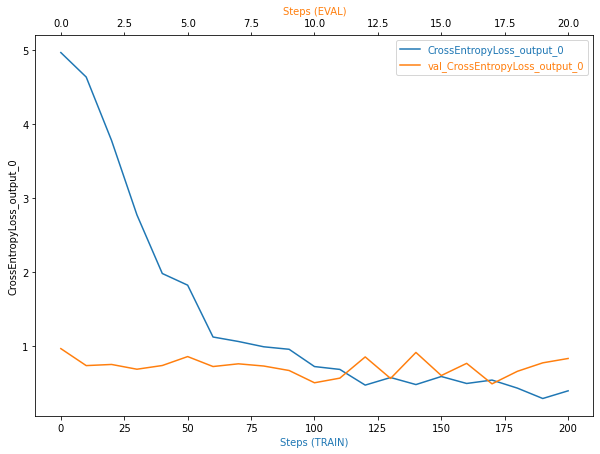

In [23]:
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
trial = create_trial(estimator.latest_job_debugger_artifacts_path())
print(trial.tensor_names())
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

#Set up functions to plot the output tensors
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals


import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()
plot_tensor(trial, "CrossEntropyLoss_output_0")

In [24]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts
import IPython
session = boto3.session.Session()
region = session.region_name
tj = TrainingJob(estimator.latest_training_job.name, region)
tj.wait_for_sys_profiling_data_to_be_available()
system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-222248610835/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 1, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 1, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }'}}
s3 path:s3://sagemaker-us-east-1-222248610835/project3-best-params-2023-03-21-22-52-09-759/profiler-output


Profiler data from system is available
[2023-03-21 23:06:39.632 pytorch-1-10-cpu-py38-ml-t3-medium-9c8fa3a7688fa232cbbe37185a11:27 INFO metrics_reader_base.py:134] Getting 11 event files
select

You will find the profiler report in s3://sagemaker-us-east-1-222248610835/project3-best-params-2023-03-21-22-52-09-759/rule-output
2023-03-21 23:04:01     415080 project3-best-params-2023-03-21-22-52-09-759/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-03-21 23:04:01     269700 project3-best-params-2023-03-21-22-52-09-759/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-03-21 23:03:56        192 project3-best-params-2023-03-21-22-52-09-759/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-03-21 23:03:56      13138 project3-best-params-2023-03-21-22-52-09-759/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-03-21 23:03:56       1974 project3-best-params-2023-03-21-22-52-09-759/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-03-21 23:03:56        326 project3-best-params-2023-03-21-22-52-09-759/rule-output/ProfilerReport/profiler-output/profiler-r

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?
There is an issue with loss not decreasing. I guess the learning rate might be too big. So I could decrease the learning rate next time I run the training job.
The initializing part takes far too long - more than 70% of all the time. Actually I am not sure how to fix this one.
The GPU has not utilized its the resources efficiently. As suggested I could increase the batch size.

**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

## Model Deploying

In [2]:
# TODO: Deploy your model to an endpoint

import sagemaker
from sagemaker.pytorch.model import PyTorchModel
role = sagemaker.get_execution_role()
model_location = 's3://sagemaker-us-east-1-222248610835/project3-best-params-2023-03-21-23-08-54-761/model.tar.gz'
    
estimator = PyTorchModel(model_data=model_location,
                             role=role,
                             entry_point='inference.py',
                             py_version='py36',
                             framework_version='1.8')

In [3]:
predictor=estimator.deploy(
    initial_instance_count=1,
    instance_type="ml.g4dn.xlarge") # TODO: Add your deployment configuration like instance type and number of instances

----------!

In [14]:
import os
path = 'dogImages/test/'
folders=os.listdir(path)
breeds = {}
for folder in folders:
    breeds[int(folder[:3])] = folder[4:]

In [15]:
#run this to pick a file randomly from the "test" folder
import random
folder=random.choice(folders)
file = random.choice(os.listdir(path + folder))

In [16]:
#change this if you want to get a file from another path
# full_path = path + folder + '/' + file
# correct_index = int(folder[:3])
# correct_breed = folder[4:]
full_path = path + folder + '/' + file
correct_index = int(folder[:3])
correct_breed = folder[4:]

6 American_eskimo_dog


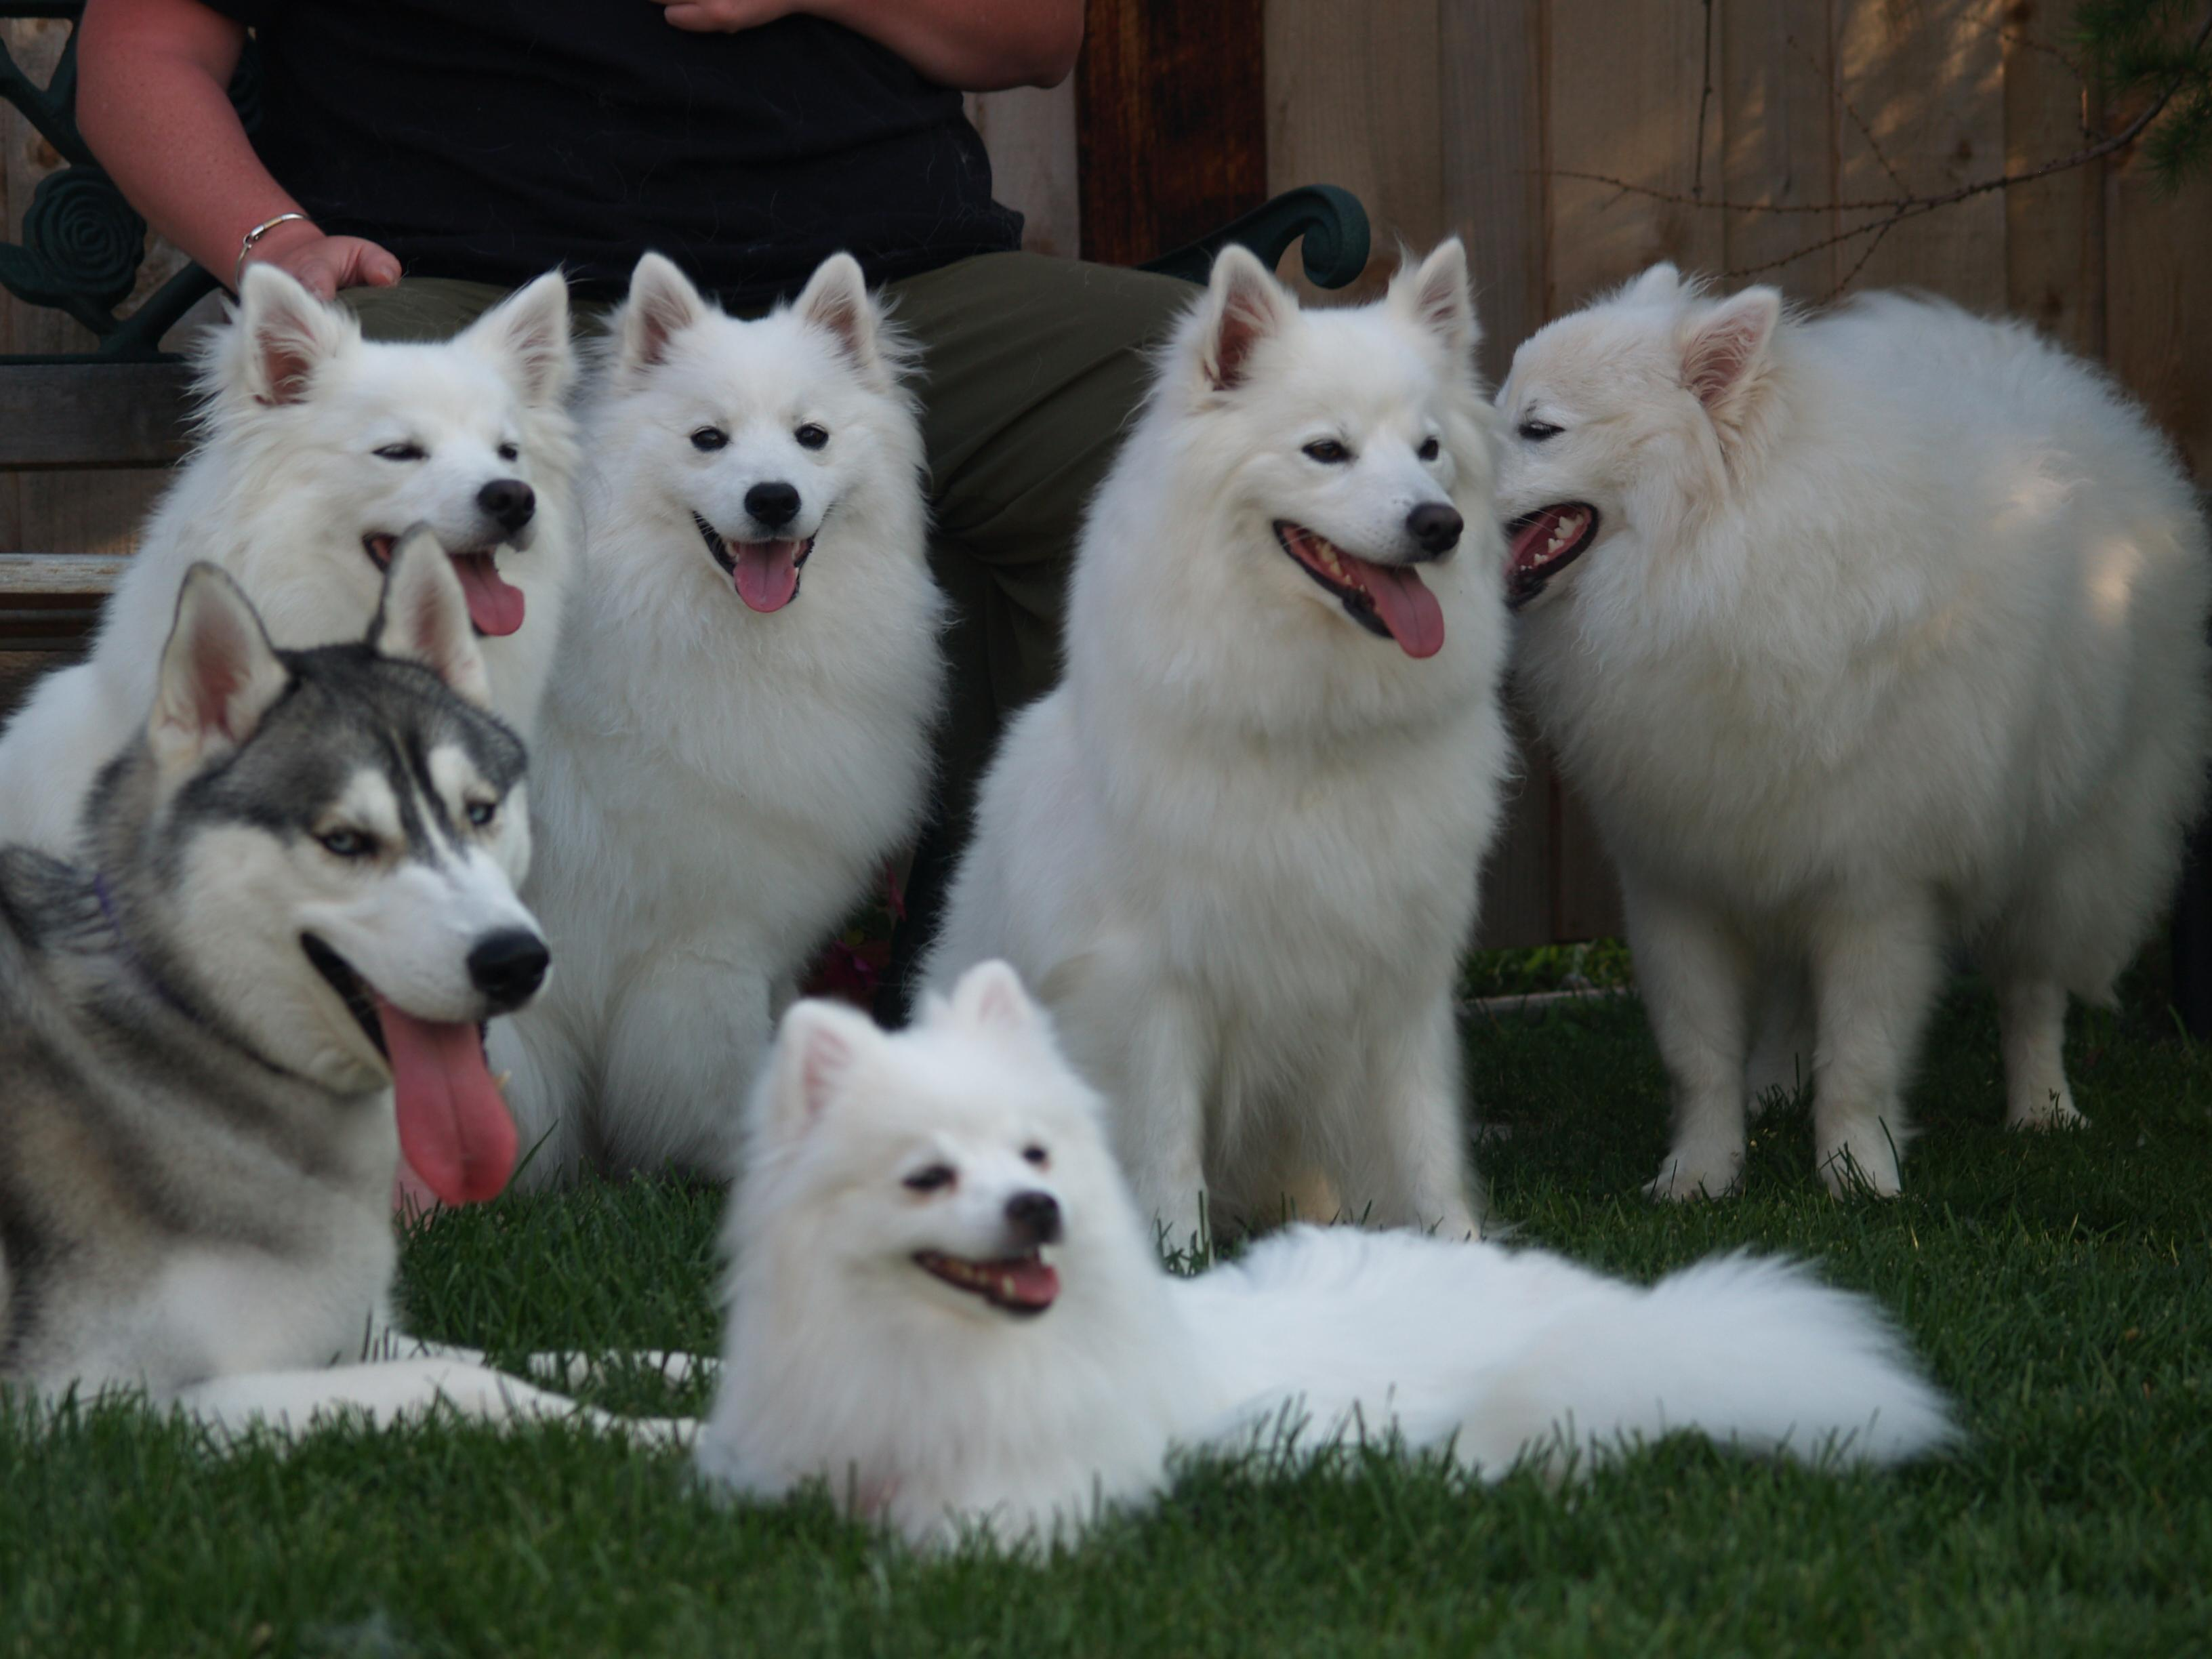

In [17]:
from PIL import Image
import io

print(correct_index, correct_breed)
with open(full_path, "rb") as f:
    payload = f.read()
img = Image.open(io.BytesIO(payload))
img

In [18]:
from torchvision import transforms
testing_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

image = testing_transform(img)# TODO: Your code to load and preprocess image to send to endpoint for prediction
image = image.unsqueeze(dim=0)

In [19]:
response = predictor.predict(image)

In [21]:
import numpy as np
predicted_index = np.argmax(response[0], axis=0) + 1
print("Predicted breed is {} - {}".format(predicted_index, breeds[predicted_index]))
try:
    if predicted_index == correct_index:
        print("Prediction is correct")
    else:
        print("Prediction is incorrect")
    print("Correct breed index is {}. The breed is {}".format(correct_index, correct_breed))
except:
      pass

Predicted breed is 6 - American_eskimo_dog
Prediction is correct
Correct breed index is 6. The breed is American_eskimo_dog


In [22]:
# # TODO: Remember to shutdown/delete your endpoint once your work is done
# predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2023-03-22-23-32-16-014
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2023-03-22-23-32-16-014
